In [2]:
#Import Libraries
import requests
from bs4 import BeautifulSoup


In [3]:
#Specify with which web page you are going to be scraping
page = requests.get('https://en.wikipedia.org/wiki/List_of_cryptocurrencies')
#Parse the HTML into the BeautifulSoup parse tree format
soup = BeautifulSoup(page.text, 'html.parser')


In [4]:
# confirm page load and title
title = soup.find('title')
print(title.string)

List of cryptocurrencies - Wikipedia


In [5]:
# Extract table containi CryptoCurrency list, and article URLs
My_table = soup.find('table',{'class':'wikitable sortable'})
#print(My_table)

In [6]:
# Get list of coins in wiki
# scrape individual coin pages for corpus
# scrape references for extended corpus
# process for distinguishing features
# Determine if distinguishing features alongside date of releace can accurately predict market cap

import re
import numpy as np
import pandas as pd

raw_cryptos = []
#get all the data stored  into <tr>
rows =  My_table.findAll('tr')

# Remove html tags from strings
def clean_headers(text):
    output = re.sub("<.+?>", "", text)
    output = re.sub(" ","_",output)
    output = re.sub("[^a-zA-Z_]", "", output)
    if output is not None:
        return output
    else:
        return text

columns=[]
headings = re.findall('(?ms)(?ms)<th>(.+?)<\/th>',str(rows[0]))

for i in range(len(headings)):
    columns.append(clean_headers(headings[i]))
    
raw_cryptos = pd.DataFrame(columns=columns)

# Add each row of cryptocurrency table 
# as a new row in Crypto Currrency Data Frame
for i in range(1,len(rows)):
    rowdata = re.findall('(?ms)(?ms)<td>(.+?)<\/td>',str(rows[i]))
    raw_cryptos.loc[len(raw_cryptos)] = rowdata[:len(raw_cryptos.columns)]

# Add column for Crypto Wiki page
raw_cryptos.insert(len(raw_cryptos.columns), "wiki_page","", allow_duplicates=True)


raw_cryptos.head(5)

,Release,Currency,Symbol,Founders,Hash_algorithm,Programming_language_of_implementation,Cryptocurrency_blockchain_PoS_PoW_or_other,Notes,wiki_page
0,2009\n,"<a href=""/wiki/Bitcoin"" title=""Bitcoin"">Bitcoi...","BTC,<sup class=""reference"" id=""cite_ref-Dixon_...","<a href=""/wiki/Satoshi_Nakamoto"" title=""Satosh...","<a href=""/wiki/SHA-2"" title=""SHA-2"">SHA-2</a>5...","<a href=""/wiki/C%2B%2B"" title=""C++"">C++</a><su...","<a class=""mw-redirect"" href=""/wiki/Proof-of-wo...",The first and most widely used decentralized l...,
1,2011\n,"<a href=""/wiki/Litecoin"" title=""Litecoin"">Lite...","LTC, Ł\n",Charlie Lee\n,"<a href=""/wiki/Scrypt"" title=""Scrypt"">Scrypt</...","<a href=""/wiki/C%2B%2B"" title=""C++"">C++</a><su...","<a class=""mw-redirect"" href=""/wiki/Proof-of-wo...",One of the first cryptocurrencies to use scryp...,
2,2011\n,"<a href=""/wiki/Namecoin"" title=""Namecoin"">Name...",NMC\n,"Vincent Durham<sup class=""reference"" id=""cite_...","<a href=""/wiki/SHA-2"" title=""SHA-2"">SHA-2</a>5...","<a href=""/wiki/C%2B%2B"" title=""C++"">C++</a><su...","<a class=""mw-redirect"" href=""/wiki/Proof-of-wo...","Also acts as an alternative, decentralized <a ...",
3,2012\n,"<a href=""/wiki/Peercoin"" title=""Peercoin"">Peer...",PPC\n,"Sunny King<br/>(pseudonym)<sup class=""noprint ...","<a href=""/wiki/SHA-2"" title=""SHA-2"">SHA-2</a>5...","<a href=""/wiki/C%2B%2B"" title=""C++"">C++</a><su...","<a class=""mw-redirect"" href=""/wiki/Proof-of-wo...",The first cryptocurrency to use POW and POS fu...,
4,2013\n,"<a href=""/wiki/Dogecoin"" title=""Dogecoin"">Doge...","DOGE, XDG, Ð\n",Jackson Palmer<br/>&amp; Billy Markus<sup clas...,"<a href=""/wiki/Scrypt"" title=""Scrypt"">Scrypt</...","<a href=""/wiki/C%2B%2B"" title=""C++"">C++</a><su...","<a class=""mw-redirect"" href=""/wiki/Proof-of-wo...","Based on the <a href=""/wiki/Doge_(meme)"" title...",


In [7]:
#  Tidy up some of the initial values
cryptos = raw_cryptos

def remove_new_line(text):
    output = re.sub("\n", "", text)
    if output is not None:
        return output
    else:
        return text

def extract_url(text):
    output = re.search('href="([^"]+)',text)
    if output is not None:
        return output.group(1)
    else:
        return text

# Remove html tags from strings
def clean_html(text):
    # Remove tags
    text = re.sub("<.+?>", "", text)
    # remove \n
    text = re.sub("\\n", "", text)
    # remove citations
    text = re.sub("\[.+?\]", "", text)
    # replace &amp; with &
    text = re.sub("&amp;", "&", text)
    return text

for i in range(len(cryptos)):
    cryptos.Release[i] = remove_new_line(cryptos.Release[i]).lower()
    cryptos.Release[i] = clean_html(cryptos.Release[i])
    cryptos.wiki_page[i] = "https://en.wikipedia.org/" + extract_url(cryptos.Currency[i]) 
    cryptos.Currency[i] = clean_html(cryptos.Currency[i]).lower()
    cryptos.Symbol[i] = re.search('(\w+)',cryptos.Symbol[i]).group(1).lower()
    cryptos.Founders[i] = clean_html(cryptos.Founders[i]).lower()
    cryptos.Hash_algorithm[i] = clean_html(cryptos.Hash_algorithm[i]).lower()
    cryptos.Programming_language_of_implementation[i] = clean_html(cryptos.Programming_language_of_implementation[i]).lower()
    cryptos.Cryptocurrency_blockchain_PoS_PoW_or_other[i] = clean_html(cryptos.Cryptocurrency_blockchain_PoS_PoW_or_other[i]).lower()
    cryptos.Notes[i] = clean_html(cryptos.Notes[i]).lower()
    
cryptos.head(5)

,Release,Currency,Symbol,Founders,Hash_algorithm,Programming_language_of_implementation,Cryptocurrency_blockchain_PoS_PoW_or_other,Notes,wiki_page
0,2009,bitcoin,btc,satoshi nakamoto,sha-256d,c++,pow,the first and most widely used decentralized l...,https://en.wikipedia.org//wiki/Bitcoin
1,2011,litecoin,ltc,charlie lee,scrypt,c++,pow,one of the first cryptocurrencies to use scryp...,https://en.wikipedia.org//wiki/Litecoin
2,2011,namecoin,nmc,vincent durham,sha-256d,c++,pow,"also acts as an alternative, decentralized dns.",https://en.wikipedia.org//wiki/Namecoin
3,2012,peercoin,ppc,sunny king(pseudonym),sha-256d,c++,pow & pos,the first cryptocurrency to use pow and pos fu...,https://en.wikipedia.org//wiki/Peercoin
4,2013,dogecoin,doge,jackson palmer& billy markus,scrypt,c++,pow,based on the doge internet meme.,https://en.wikipedia.org//wiki/Dogecoin


In [8]:
# Build corpus, and link list for each coin
corpus = pd.DataFrame(columns=['coin', 'ticker','document_url','document'])
link_list = pd.DataFrame(columns=['coin', 'ticker', 'document_url'])

#Specify with which web page you are going to be scraping
page = requests.get('https://en.wikipedia.org/wiki/List_of_cryptocurrencies')
#Parse the HTML into the BeautifulSoup parse tree format
soup = BeautifulSoup(page.text, 'html.parser')

# Remove citation [302] and quotes "quote"
# and non ASCII text
def clean_body_text(text):
    output = re.sub("\[\w*\]", "", text)
    output = re.sub('"', "", output)
    output = re.sub('[^a-zA-Z\.,\'\(\)\d\s]', "", output)
    if output is not None:
        return output
    else:
        return text

# Iterate through list of crypto currencies
# Ingest article into corpus for analysis, 
# and scrape reference URLs into link list

for i in range(len(cryptos)):
    page = requests.get(cryptos.wiki_page[i])
    soup = BeautifulSoup(page.text, 'html.parser')
    #print("***************************************")
    #print(str(cryptos.wiki_page[i]) + " Status(" + str(page.status_code) + ")")

    
    # Check that the page loaded corectly
    if page.status_code==200:
        # Fetch all paragraph text and load each paragraph into the corrpus
        page_body = soup.find_all('p')
        
        # Get all paragraph text from page
        page_body = soup.find_all('p')

        #construct complete page text
        complete_page_text = ""
        for paragraph in page_body:
            complete_page_text += clean_body_text(paragraph.text).lower() + "\n"

        corpus.loc[len(corpus)] = [cryptos.Currency[i], cryptos.Symbol[i], cryptos.wiki_page[i] , complete_page_text]
                
        
        # Fetch References
        # References are in an ordered list
        # with IDs begining with cite_note
        references = soup.find_all('li', {"id" : re.compile('cite.*')})
        references = soup.find_all('a', {"class" : "external text"})
        for ref in references:
            if ("wikipedia" not in ref.get('href')) and (".pdf" not in ref.get('href')):
                #print(ref.get('href'))
                #print(" ")
                link_list.loc[len(link_list)] = [cryptos.Currency[i], cryptos.Symbol[i], ref.get('href')]

print("Current Corpus size: " + str(len(corpus)))
print("Reference list size: " + str(len(link_list)))

Current Corpus size: 26
Reference list size: 1308


In [9]:
##############################
## Iterate through Wiki references for crypto currencies for
## An expanded corpus
## Pages that don't contain either a reference to the crypto currency name
## or ticker are discarded...

expanded_corpus = corpus.copy(deep=True)
    
    
for i in range(len(link_list)):
    try:
        page = requests.get(link_list.document_url[i])
    except Exception as e:
        print("Page load error." + str(e))
    soup = BeautifulSoup(page.text, 'html.parser')
    #print("Page(" + str(i) +")" + str(link_list.document_url[i]))
    
    # save corpus every 50 pages
    if i%50==0:
        expanded_corpus.to_csv ('expanded_corpus.csv', index = None, header=True)
        print("Page(" + str(i) +")" + str(link_list.document_url[i]))
        
    if page.status_code==200:
        page_text = soup(text=True)

        # Get all paragraph text from page
        page_body = soup.find_all('p')

        #construct complete page text
        complete_page_text = ""
        for paragraph in page_body:
            complete_page_text += clean_body_text(paragraph.text).lower() + "\n"

        # if page text contains the currency name or ticker, add it to the corpus
        if (link_list.coin[i] in complete_page_text) or (link_list.ticker[i] in complete_page_text):
            expanded_corpus.loc[len(expanded_corpus)] = [link_list.coin[i], link_list.ticker[i], link_list.document_url[i], complete_page_text]

expanded_corpus

# save corpus once complete
expanded_corpus.to_csv ('expanded_corpus.csv', index = None, header=True)

Page(0)https://bitcoin.org
Page load error.HTTPConnectionPool(host='www.dailytech.com', port=80): Max retries exceeded with url: /Cracking+the+Bitcoin+Digging+Into+a+131M+USD+Virtual+Currency/article21878.htm (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000024F22950940>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))
Page(50)https://www.businessinsider.com/did-shinichi-mochizuki-invent-bitcoin-2013-5
Page load error.HTTPSConnectionPool(host='bitcoincharts.com', port=443): Max retries exceeded with url: /charts/mtgoxUSD (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)')))
Page load error.HTTPSConnectionPool(host='bitcoincharts.com', port=443): Max retr

Page load error.No connection adapters were found for '//www.google.com/search?&q=%22Titcoin%22+site:news.google.com/newspapers&source=newspapers'
Page load error.Invalid URL '//scholar.google.com/scholar?q=%22Titcoin%22': No schema supplied. Perhaps you meant http:////scholar.google.com/scholar?q=%22Titcoin%22?
Page load error.HTTPConnectionPool(host='www.designntrend.com', port=80): Max retries exceeded with url: /articles/15814/20140623/porn-gets-currency.htm (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000024F2225B3D0>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))
Page load error.HTTPConnectionPool(host='majormindjob.com', port=80): Max retries exceeded with url: /wolf/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000024F2

In [10]:
#################################################
## Call coinmarketcap api, to get current data for a wide range of cryptos
##  This code was taken from coinmarketcap.com
## In their developer tools documentation

from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
parameters = {
  'start':'1',
  'limit':'5000',
  'convert':'USD'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': '72a57e6d-26fa-4651-b991-ef8ab839756d',
}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  data = json.loads(response.text)
  print(data)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
##################################################
##  Get coin names and market cap from data

# Split the json payload returned by coinmarketcap
# on the id field to separate out the coins
api_coins = str(data).split("{'id")

# Create a new data frame to contain the current market capitalisation
# for each crypto currency
coin_market_caps = pd.DataFrame(columns=['symbol','marketcap'])

# Returns the first capture group from an re regex sreach
# and returns an empty string if None
def none_to_string(text):
    if text is not None:
        return text.group(1)
    else:
        return ""

# capture the symbol, and market cap for each coin object from the 
# initial json payload
for coin in api_coins:
    symbol = none_to_string(re.search("symbol':\s'(\w+)",coin))
    cap = none_to_string(re.search("market_cap':\s([\d\.]+)", coin))
    coin_market_caps.loc[len(coin_market_caps)] = [symbol.lower(),cap]

coin_market_caps.head(5)

,symbol,marketcap
0,,
1,btc,942542420868.065
2,eth,259669132297.44815
3,bnb,76050892938.45325
4,usdt,


In [12]:
coin_market_caps.to_csv ('coin_market_caps.csv', index = None, header=True)

<AxesSubplot:>

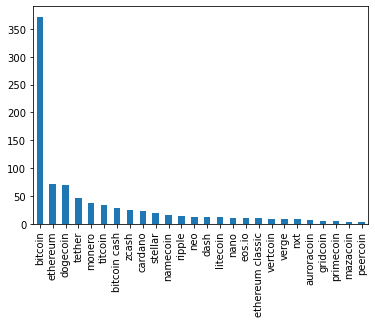

In [13]:
#############################################
## Check document count for each crypto currency

frequency = expanded_corpus['coin'].value_counts(sort=True)

frequency.head(50).plot.bar()

In [15]:
expanded_corpus.head(2)

,coin,ticker,document_url,document
0,bitcoin,btc,https://en.wikipedia.org//wiki/Bitcoin,\n\n\n\nbitcoin () is a cryptocurrency invente...
1,litecoin,ltc,https://en.wikipedia.org//wiki/Litecoin,litecoin (ltc or ) is a peertopeer cryptocurre...


In [16]:
expanded_corpus.document[0]

"\n\n\n\nbitcoin () is a cryptocurrency invented in 2008 by an unknown person or group of people using the name satoshi nakamoto. the currency began use in 2009 when its implementation was released as opensource software.ch. 1 bitcoin is a decentralized digital currency, without a central bank or single administrator, that can be sent from user to user on the peertopeer bitcoin network without the need for intermediaries. transactions are verified by network nodes through cryptography and recorded in a public distributed ledger called a blockchain.\n\nbitcoins are created as a reward for a process known as mining. they can be exchanged for other currencies, products, and services, but the realworld value of the coins is extremely volatile. research produced by the university of cambridge estimated that in 2017, there were 2.9 to 5.8 million unique users using a cryptocurrency wallet, most of them using bitcoin. users choose to participate in the digital currency for a number of reasons